# Project: Evaluating Deep-Learning Models for Detecting Orientation and Flipping of X-Ray Scans
## Objective: Develop a Reliable Method to Detect Orientation and Flipping of Lateral Ceph Scans in the BB-Collection
---
### Background

In the BB-Collection, we identified several TIFF scans with inconsistent rotation and flipping. Specifically, Lateral Cephs should be oriented to the right and upwards.

### Strategy

Based on the findings in the work of Swami et al. [[1]](#References), we've determined that deep learning (DL) is the most appropriate method to accomplish this task.  
Specifically, we will make use of pre-trained models through *transfer learning*. This is the process of fine-tuning a model that has already been trained on millions of images to recognize more than 1000 classes of objects.  

We will evaluate various models with different architectures and sizes (number of neurons and layers), and assess their performance specifically within the context of the BB-Collection.  

### Preparing the trainig-set
We will use a subset of the BB-Collection scans, specifically the *Laterals* that are available on the AAOF website which are already correctly oriented (patient looking to the right).  
For each file we need to generate all possible combinations of rotation (in 90 degrees steps) and flip. We will use this augmented dataset to train the DL models.

In [23]:
# Usual imports

from fastai.vision.all import *
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.patches as patches
import pickle
import re
from skimage import exposure, io, color

In [24]:
# Augment the dataset:
# For each file generate all possible combinations of rotation and flip

path = Path("BB_AAOF_WEB/Laterals")
train_folder = "Train/FlipRot/"
scans = list(path.glob("*.jpg"))
print(f"{len(scans)} Lateral scans in the BB_AAOF web collection")

1066 Lateral scans in the BB_AAOF web collection


In [ ]:
rotations = [90, 180, 270]

for scan in scans:
    img = Image.open(scan)
    img.save(f"{train_folder}/{scan.stem}_0.png")
    img_flip = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    img_flip.save(f"{train_folder}/{scan.stem}_0F.png")
    for rot in rotations:
        # img_rot = img.rotate(rot)
        img_rot = img.transpose(Image.Transpose[f"ROTATE_{rot}"])
        img_rot.save(f"{train_folder}/{scan.stem}_{rot}.png")
        img_rot_flip = img_rot.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        img_rot_flip.save(f"{train_folder}/{scan.stem}_{rot}F.png")

In [25]:
files = get_image_files("Train/FlipRot_HE/")
print(f"{len(files)} BB_AAOF web collection files augmented with all possible rotation/flip combinations + non-laterals for training")

12624 BB_AAOF web collection files augmented with all possible rotation/flip combinations + non-laterals for training


In [26]:
# Set up fastai dataloaders and model to start training

# This function generates labels based on filenames
def label_func(f):
    match = re.search(r'.*_([^_]+)\.png', f)
    return match.group(1)

def image_he(img: Image.Image) -> Image.Image:
    np_img = np.array(img.convert('L'))
    he_img = exposure.equalize_hist(np_img) * 255
    return PILImage.create(he_img.astype(np.uint8))

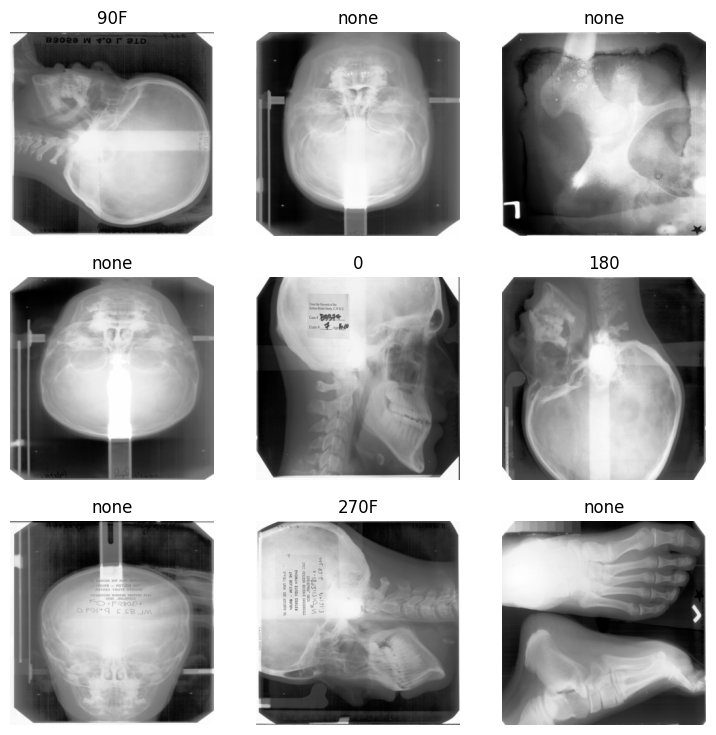

In [27]:
# Fastai dataloader - bundles images and labels for training the model

dls = ImageDataLoaders.from_name_func(train_folder, files, label_func,
                                      item_tfms=[Resize(size=299, method=ResizeMethod.Squish)],
                                      seed=42)

dls.show_batch(cmap='gray')

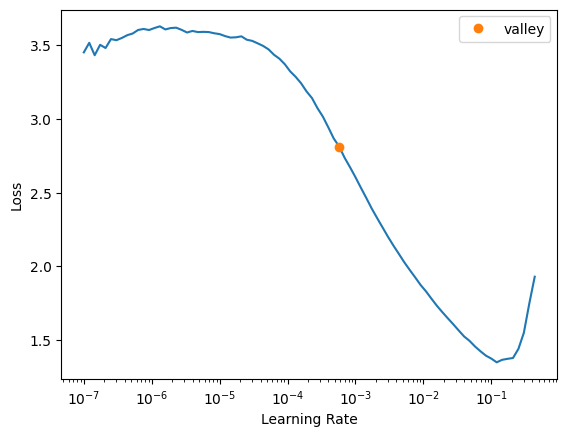

In [32]:
# Fastai pre-trained model 'Resnet34', quantized to fp16 to reduce computational and memory requirements
# We use fastai's learning rate finder to get a good range for this key hyperparameter to train the model

learn = vision_learner(dls, resnet50, metrics=accuracy)
learn.to_fp16()
lr = learn.lr_find()

In [33]:
# Next, we train (or fine-tune) the model for 30 epochs using the learning rate determined in the previous step

learn.fine_tune(30, lr.valley * 10)

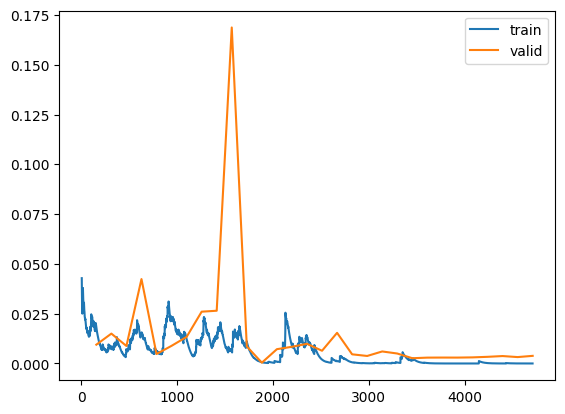

In [34]:
learn.recorder.plot_loss()

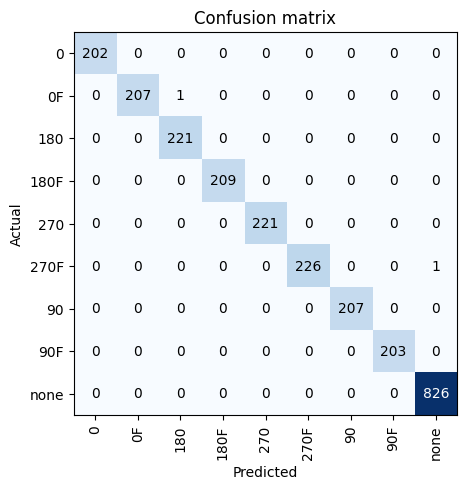

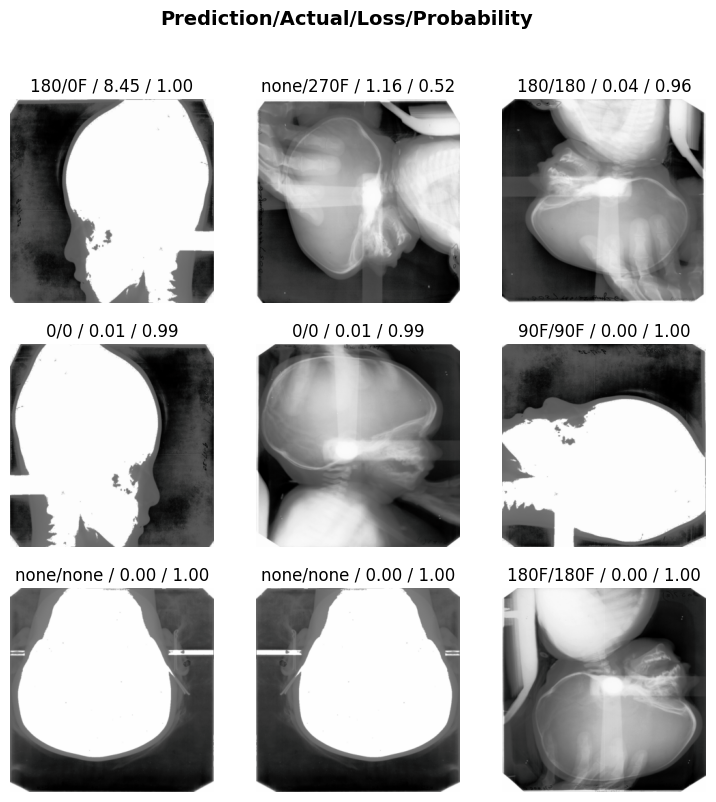

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9)

Fine-tuning a relatively small model (Resnet50) for 15 epochs results in an accuracy of 100%.  
After inspecting various metrics (train/validation loss, confusion matrix, etc..) we save the trained model for future use.

In [36]:
learn.path = Path("./")
learn.export("models/fliprot_resnet50_fp16_02")

### Insights and Observations
The metrics look good, but an accuracy of 99.9% may suggest overfitting.  
We should test the model against unseen data (the test set) to confirm that the model has generalized well and has not overfit.

### Validation against unseen data
We compare the contents of our 'Train' folder (used for model training) with the 'Scans' folder (containing data from unseen patients) to identify how many new patients we have available to validate our model.

In [37]:
ls -l Scans/ | grep "^d" | wc -l

369


There are 369 patients in the Scans folder.  
Naming for laterals is not standardized, we need to take this into account.

In [38]:
# We need only laterals so we prepare a list with all different lateral folder names that occur in the Scans folder

folder = Path('Scans')
laterals = {d.name for d in folder.glob('*/*') if d.is_dir() and "lat" in d.name.lower()}
laterals

{'Lateral', 'Lateral Ceph', 'Lateral Skull', 'LateralCeph', 'Laterals'}

In [39]:
# Next we prepare a list with all lateral scans

files = folder.rglob("*.png")
scans = []
for f in files:
    if any([s in str(f) for s in laterals]):
        scans.append(f)

print(f"{len(scans)} lateral scans in Scans folder\nRandom sample:")
random.sample(scans, 3)

2712 lateral scans in Scans folder
Random sample:


[Path('Scans/B3058/Lateral/B3058L11.png'),
 Path('Scans/B3007/Lateral/B3007LM20y00m 2.png'),
 Path('Scans/B2014/Lateral/B2014LM10y03m.png')]

In [40]:
# Let's check the number of patients we have in the Scans folder

scans_patients = {p.parts[1] for p in scans}
print(f"{len(scans_patients)} Patients in Scans with Laterals\nRandom sample:")
print(random.sample(list(scans_patients), 5))

292 Patients in Scans with Laterals
Random sample:
['B0564', 'B0534', 'B3849', 'B0639', 'B2687']


In [41]:
# Let's check the number of patients in the BB_AAOF_WEB  folder

patients = set()
pattern = re.compile(r'CASEBolton(B\d{4}).*\.jpg$')
web_images = Path('BB_AAOF_WEB/Laterals')
for file_path in web_images.rglob('*.jpg'):
    filename = file_path.name
    match = pattern.search(filename)
    if match:
        # The first group contains the match we're interested in
        patients.add(match.group(1))

print(f"{len(patients)} Patients in BB_AAOF_WEB\nRandom sample:")
print(random.sample(list(patients), 5))

102 Patients in BB_AAOF_WEB
Random sample:
['B2130', 'B2007', 'B0261', 'B3084', 'B2702']


In [42]:
# Compare the 2 sets of Patients and compute the difference (patients not present in the training-set)

unseen_patients = scans_patients - patients
print(f"{len(unseen_patients)} 'unseen' patients with laterals")

279 'unseen' patients with laterals


In [43]:
# Finally we compile a list with all unseen lateral scans for validating the model

unseen_scans = [scan for scan in scans if not any(patient in str(scan) for patient in patients)]
print(f"{len(unseen_scans)} 'unseen' lateral scans")

2431 'unseen' lateral scans


We will next validate our trained model on a random sample of 100 items from the list of unseen lateral scans.  
Scans for which the model exhibited less than 85% confidence will be marked with a red rectangle.

In [59]:
# Load the saved model if present

model = Path('models/fliprot_resnet18_fp16_01')
if model.exists():
    learn = load_learner(model)

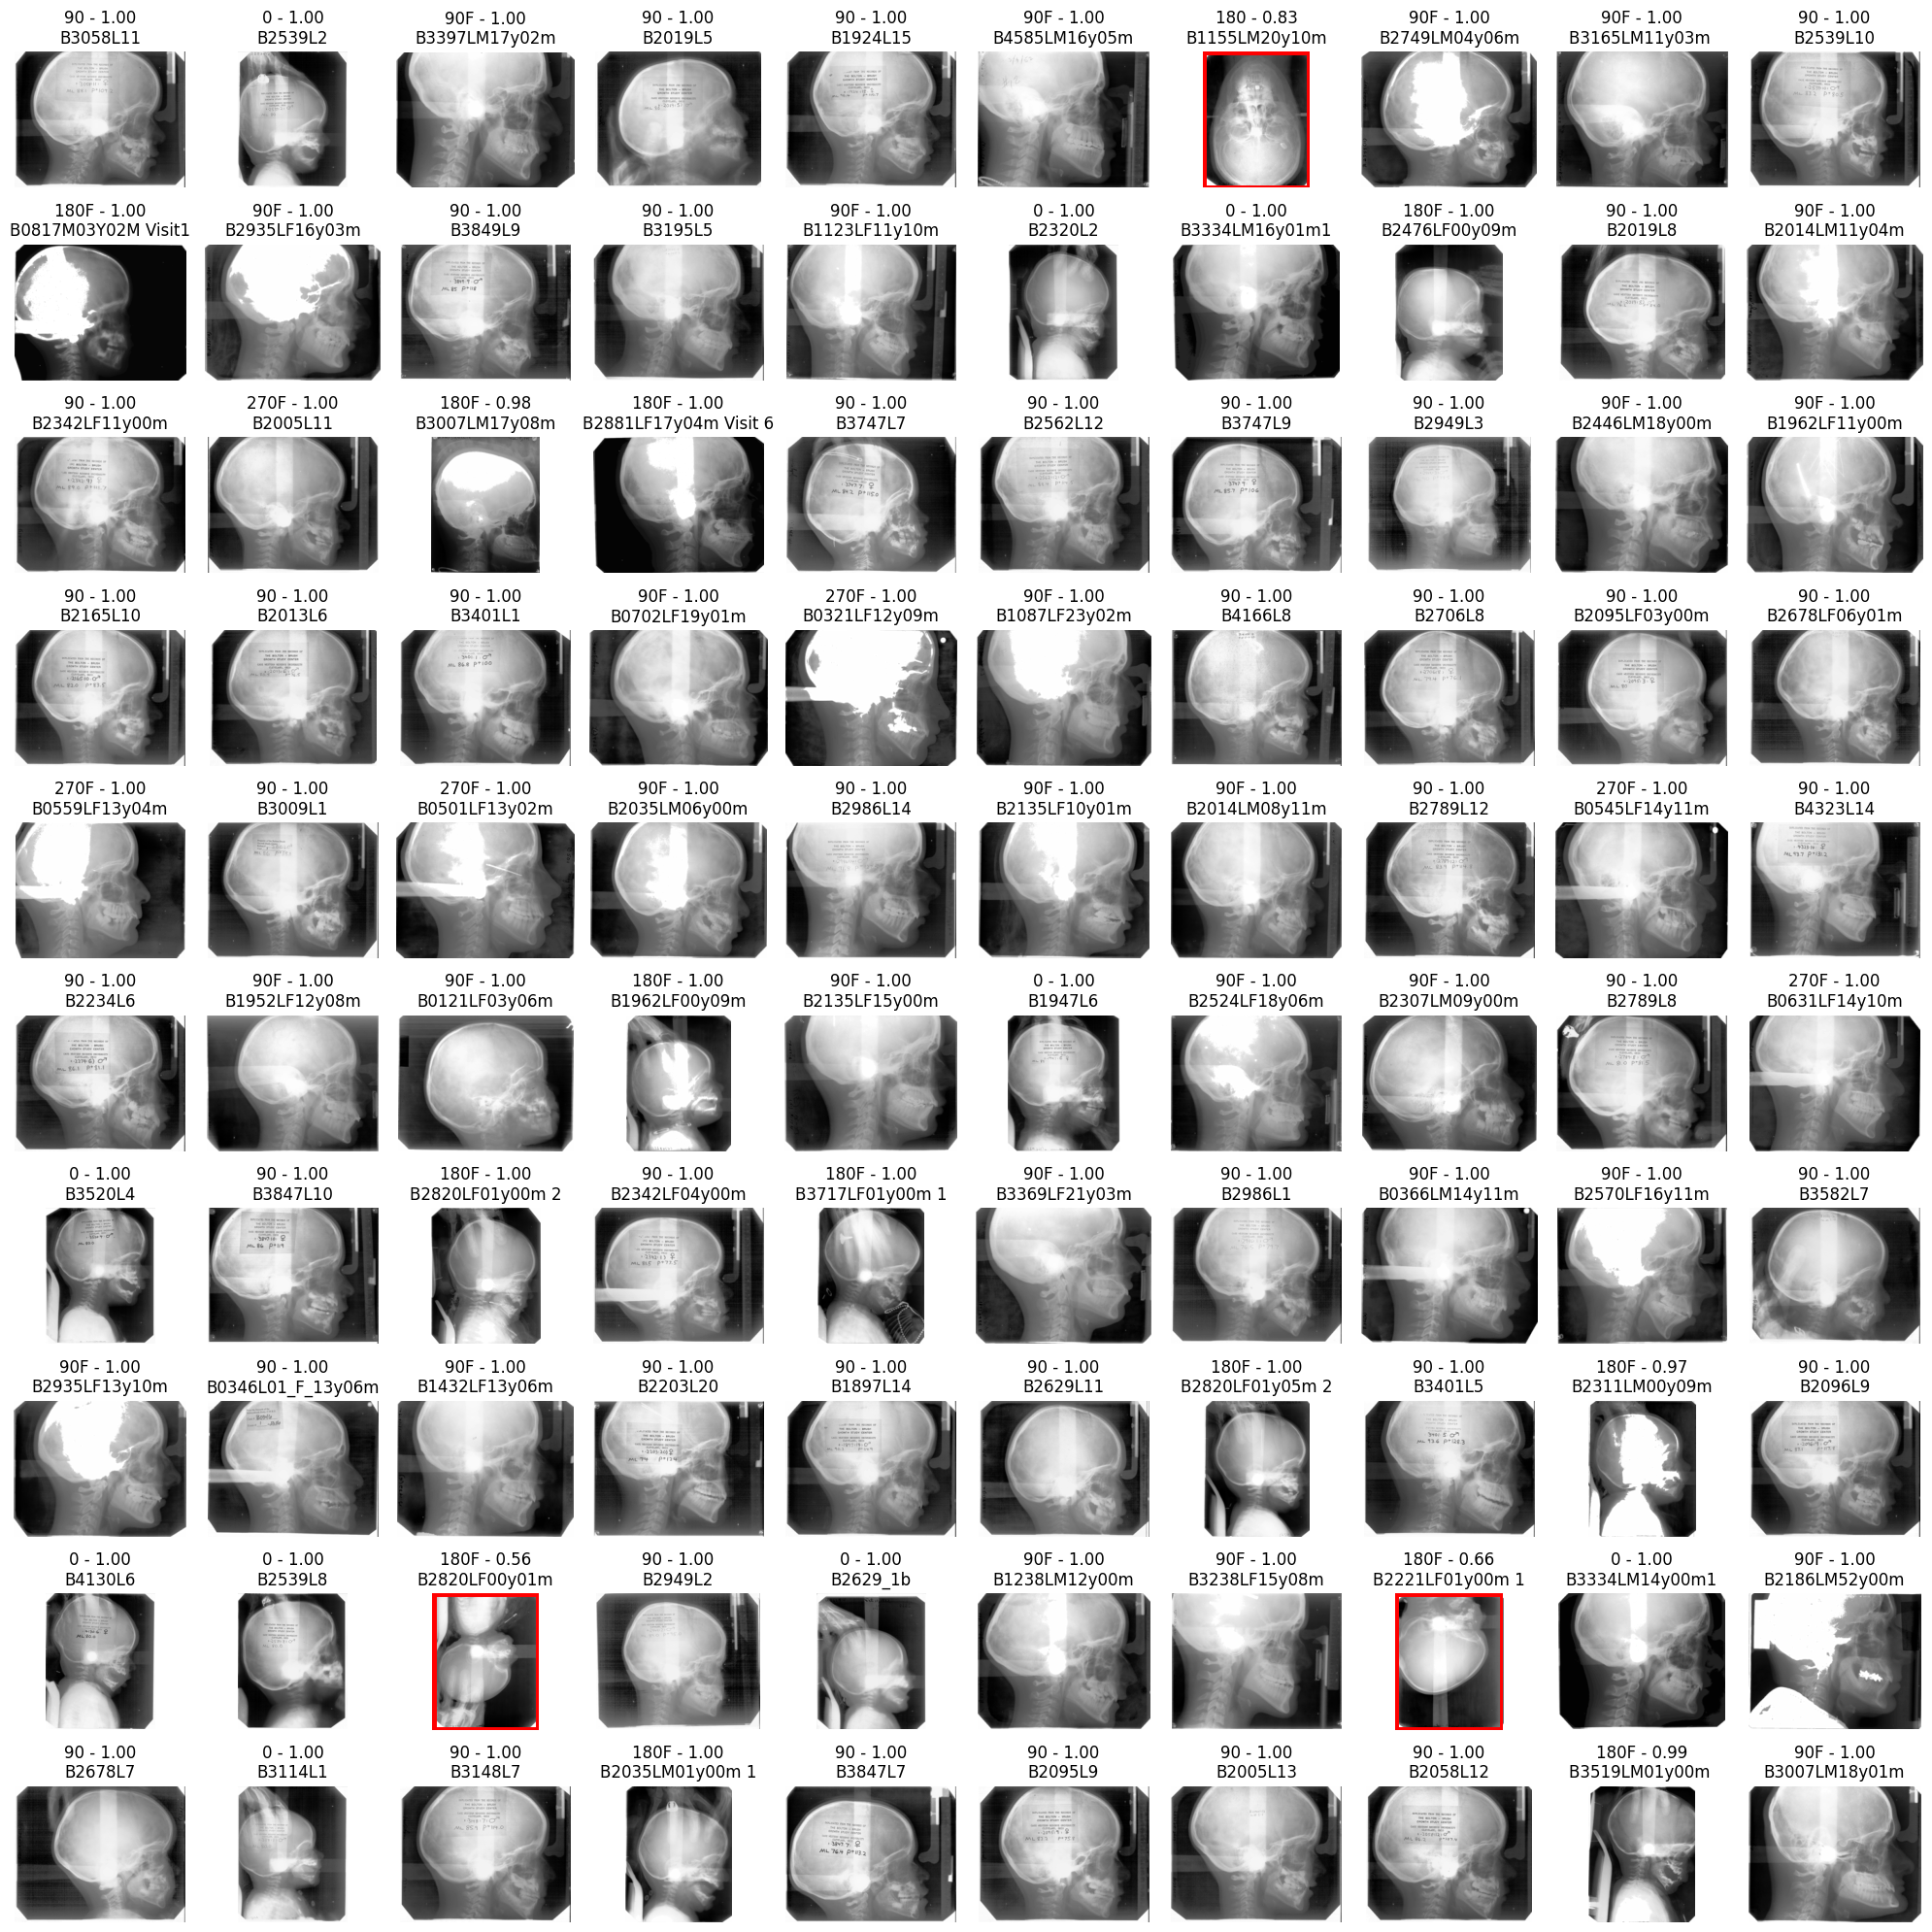

In [62]:
grid_x = 10
grid_y = 10

random.seed()
sample_images = random.sample(unseen_scans, grid_x * grid_y)

# Initialize a new plot
fig, axs = plt.subplots(grid_y, grid_x, figsize=(20, 20))

# Open and display each image
for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    img_arr = np.array(img.convert('L'))
    img_he = exposure.equalize_hist(img_arr)
    img = Image.fromarray((img_he * 255).astype(np.uint8))
    pred_class, pred_idx, outputs = learn.predict(img)
    label = str(pred_class)
    confidence = float(outputs[pred_idx])
    img.thumbnail((256,256))
    if (confidence >= 0.85):
        match label:
            case "0F":
                img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
            case "90":
                img = img.transpose(Image.Transpose.ROTATE_270)
            case "270":
                img = img.transpose(Image.Transpose.ROTATE_90)
            case "180":
                img = img.transpose(Image.Transpose.ROTATE_180)
            case "90F":
                img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
                img = img.transpose(Image.Transpose.ROTATE_270)
            case "180F":
                img = img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
            case "270F":
                img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
                img = img.transpose(Image.Transpose.ROTATE_90)
    
    ax = axs[i // grid_x, i % grid_x]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{label} - {confidence:.2f}\n{img_path.stem}")
    ax.axis('off')

    if (confidence < 0.85):
        rect = patches.Rectangle((0,0),img.shape[1],img.shape[0],linewidth=5,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    if (label == "none"):
        rect = patches.Rectangle((0,0),img.shape[1],img.shape[0],linewidth=5,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

plt.tight_layout()

Running the model on the random sample reveals some issues:
- The model erroneously classified some scans as non-laterals.
- The model erroneously classified some rotations/flippings
- The model correctly predicts rotation/flip but with a low confidence in some cases
  
Next, we will process the scans to collect all predictions and subsequently inspect cases where confidence is less than 90%.

In [63]:
preds_pkl = Path('predictions_resnet18_fp16_01.pkl')

if preds_pkl.exists():
    with open(preds_pkl, 'rb') as f:
        preds = pickle.load(f)
else:
    preds = []
    for scan in unseen_scans:
        img = io.imread(scan, as_gray=True)
        img_he = exposure.equalize_hist(img)
        img = (img_he * 255).astype(np.uint8)
        pred_class, pred_idx, outputs = learn.predict(img)
        label = str(pred_class)
        confidence = float(outputs[pred_idx])
        preds.append({
            "name": scan,
            "label": label,
            "conf": confidence
        })

    with open("predictions_resnet18_fp16_01.pkl", "wb") as f:
        pickle.dump(preds, f)

In [64]:
filtered_preds = [p for p in preds if p["conf"] < 0.9]
len(filtered_preds)

35

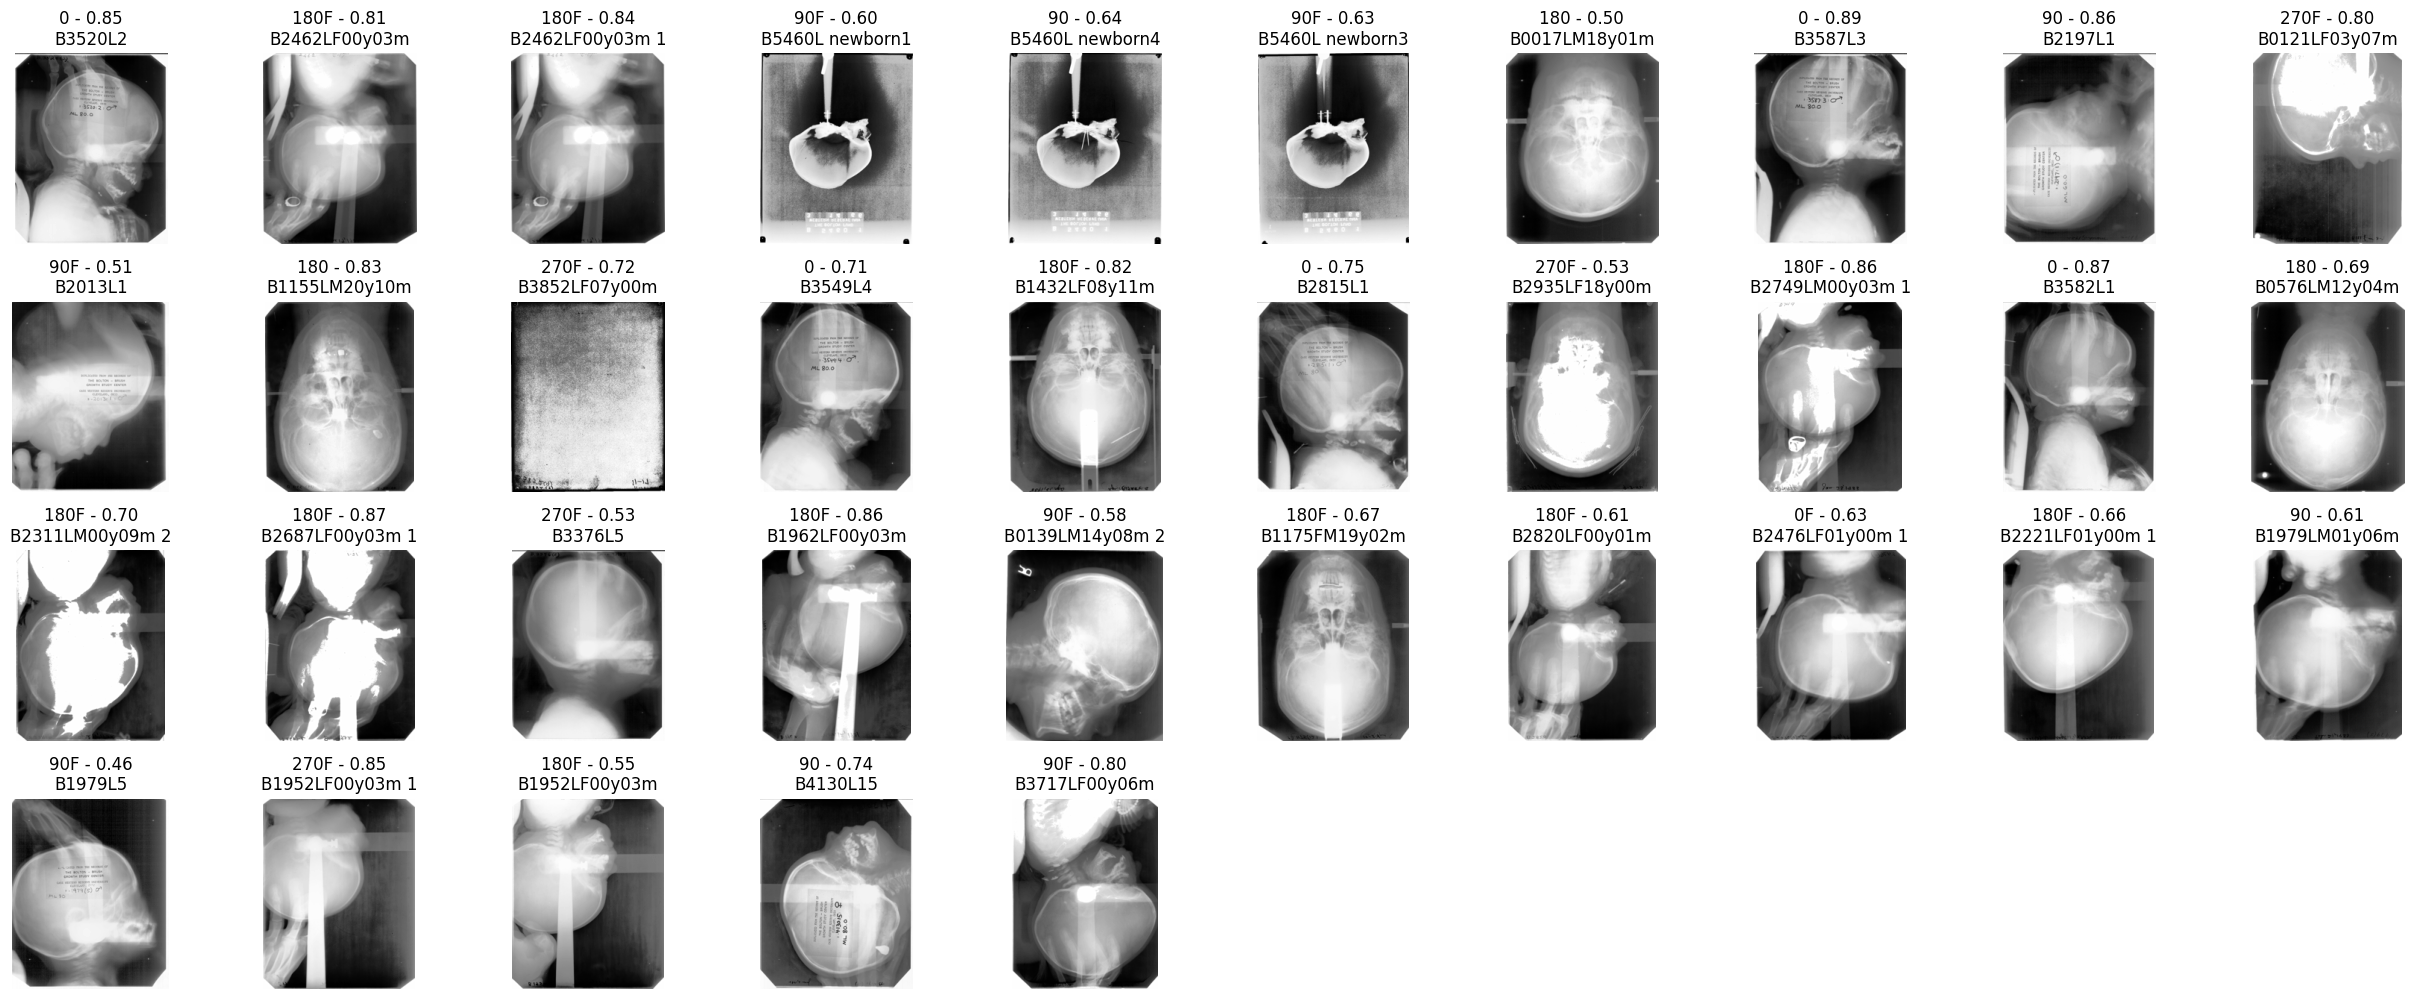

In [65]:
rows = 10
cols = 10
fig, axs = plt.subplots(rows, cols, figsize=(25, 25))
axs = axs.ravel()
for i, pred in enumerate(filtered_preds):
    img = Image.open(pred['name'])
    img_arr = np.array(img.convert('L'))
    img_he = exposure.equalize_hist(img_arr)
    img = Image.fromarray((img_he * 255).astype(np.uint8))
    img.thumbnail((256,256))
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"{pred['label']} - {pred['conf']:.2f}\n{pred['name'].stem}")
    axs[i].axis('off')

if len(filtered_preds) < len(axs):
    for j in range(len(filtered_preds), len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Out of 2431 'unseen' lateral scans, only 3 predictions resulted in a confidence level below 90%:

- Some predictions are correct but have a confidence level below 85%.
- Some predictions are incorrect.
- Some scans are of poor quality (these should be discarded).

### Insights and Observations
Although the model exhibits strong performance on unseen data, several modifications could enhance its reliability:

- Experiment with a larger, more complex model (i.e., a deeper architecture).
- Retrain the model on more data
- Determine an ideal "confidence threshold," potentially below 85%, to accommodate correctly inferred rotations even with confidence levels below 85%.

From a comprehensive perspective, it could be advantageous to train a "root" or "master" model on X-ray type classifications (e.g., frontal, lateral, chest). This model would serve as the initial step in a multi-stage pipeline, with each scan first being processed by the master model before being passed onto a specialized model.  
This approach could effectively prevent instances where non-lateral scans are erroneously processed by a lateral-processing model, thereby reducing unwarranted and incorrect predictions from specialized child models.

---
### References
[1]: K. Swami, P. P. Deshpande, G. Khandelwal and A. Vijayvargiya, "Why my photos look sideways or upside down? Detecting canonical orientation of images using convolutional neural networks," 2017 IEEE International Conference on Multimedia & Expo Workshops (ICMEW), Hong Kong, China, 2017, pp. 495-500, doi: 10.1109/ICMEW.2017.8026216.